# Задание 1: Fourier Features

Давайте имплементируем маппинг 2D координат в [Fourier Features](https://arxiv.org/abs/2006.10739) и посмотрим как он помогает запитить картинку.


Для начала попробуем зафитить картинку без Fourier Features.

Загрузим картинку по ссылке:

/tmp/ipykernel_48289/3603068419.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_url)[..., :3] / 255.


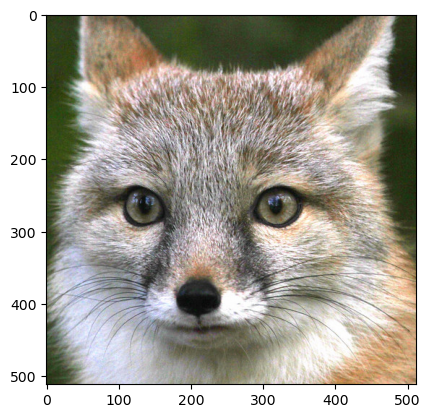

In [1]:
import imageio
import matplotlib.pyplot as plt

# Download image, take a square crop from the center
image_url = 'https://live.staticflickr.com/7492/15677707699_d9d67acf9d_b.jpg'
img = imageio.imread(image_url)[..., :3] / 255.
c = [img.shape[0]//2, img.shape[1]//2]
r = 256
img = img[c[0]-r:c[0]+r, c[1]-r:c[1]+r]

plt.imshow(img)
plt.show()

Теперь объявите класс многослойного перцептрона с 5ю слоями и фигмоидной активацией на конце.
Для скрытых слоём можете использовать ReLU.

На вход перцептрон должен принимать вектора размера 2 (2D координаты пикселя) а на выход выдавать 3х-мерные вектора (RGB)

In [2]:
import torch


DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device {DEVICE}')

Using device cuda


In [3]:
# TODO: объявить класс перцептрона
import torch.nn as nn
from torch import Tensor


class MLP(nn.Module):

    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 3),
            nn.Sigmoid(),
        )

    def forward(self, coords: Tensor) -> Tensor:
        return self.model(coords)

In [4]:
mlp = MLP()
mlp(Tensor([1, 2]))

tensor([0.5236, 0.4891, 0.5169], grad_fn=<SigmoidBackward0>)

Теперь создадим тренировочный и тестовый "датасеты".

В тестовом датасете $(X_{test}, Y_{test})$,

$Y_{test}\in \mathbb{R}^{512^2\times3}$ это все пиксели картинки, то есть 262144 ($512^2$) 3х-мерных векторов.

$X_{test}\in [0,1]^{512^2\times2}$ это нормированные координаты каждого пикселя (на отрезке от 0 до 1)


Для тренировочного датасета $(X_{train}, Y_{train})$, также возьмите пиксели картинки и координаты пикселей, но со страйдом 2

$Y_{train}\in \mathbb{R}^{256^2\times3}$ это пиксели картинки со страйдом 2, то есть 65536 ($256^2$) 3х-мерных векторов.

$X_{train}\in [0,1]^{256^2\times2}$ это нормированные координаты каждого тренировочного пикселя (на отрезке от 0 до 1)


In [5]:
# TODO: создать тренировочный и тестовый датасеты
from torch.utils.data import Dataset, DataLoader
import numpy as np
from typing import Tuple


NON_EMPTY_MASK = 1



class Coord2PixelDataset(Dataset):
    def __init__(self, image: np.ndarray, stride: int):
        self.image = Tensor(image).to(DEVICE)
        self.mask = Tensor(np.atleast_3d(np.zeros(image.shape[:2], dtype=np.int32))).to(DEVICE)
        self.mask[::stride, ::stride] = NON_EMPTY_MASK
        self.coords, self.colors = _prepare_coords(self.mask, self.image)


    def __getitem__(self, idx: int) -> Tuple[Tensor, Tensor]:
        return self.coords[idx], self.colors[idx]


    def __len__(self) -> int:
        return len(self.coords)

    @property
    def masked(self) -> Tensor:
        return self.mask * self.image

    @property
    def from_mask(self) -> Tensor:
        height = int(torch.sum(self.mask[0, :]).item())
        return self.colors.reshape(height, -1, 3)

    def show(self):
        plt.imshow(self.masked.detach().cpu())
        plt.show()


def _prepare_coords(mask: Tensor, image: Tensor) -> Tuple[Tensor, Tensor]:
    height, width = image.shape[:2]
    coords = torch.argwhere(mask == NON_EMPTY_MASK)[:, :2]
    # colors = torch.where(mask == NON_EMPTY_MASK, image, image).reshape(-1, 3)
    colors = torch.masked_select(image, (mask == NON_EMPTY_MASK)).reshape(-1, 3)
    assert len(colors) == len(coords), f'{len(colors)=} does not match {len(coords)=}'
    return coords / Tensor([[height, width]]).to(DEVICE), colors

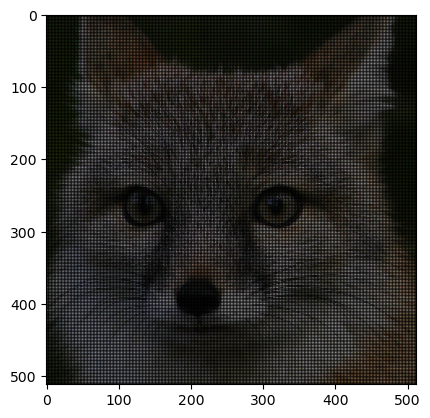

In [6]:
train_dataset = Coord2PixelDataset(img, stride=2)
assert len(train_dataset) == 256 * 256, 'Unexpected dataset size'
train_dataset.show()

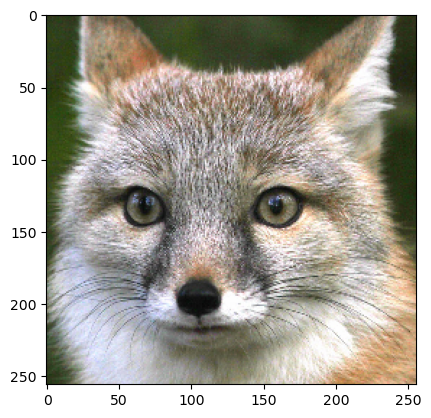

In [7]:
# Sanity check: from vector of colors back to image, resolution is smaller because of stride
plt.imshow(train_dataset.from_mask.cpu())
plt.show()

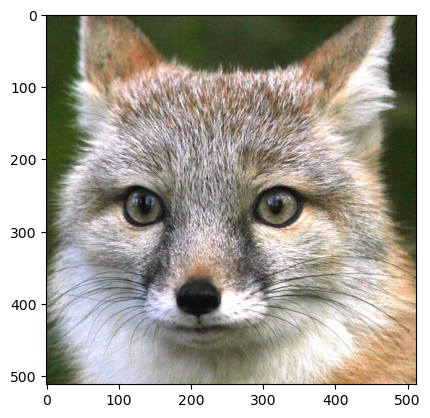

In [8]:
test_dataset = Coord2PixelDataset(img, stride=1)
assert len(test_dataset) == 512 * 512, 'Unexpected dataset size'
test_dataset.show()

Теперь напишем оптимизационный цикл. Пока без Fourier Features.


Создайте оптимизатор (например, Adam с lr=1e-4).

И в каждой итерации цикла трансформируйте тренировочный координаты $X_{train}\in [0,1]^{256^2\times2}$ в предсказание цветов $\hat{Y}\in \mathbb{R}^{256^2\times3}$

В качестве лосса возьмите простую $l_2$ норму по пикселям: $\mathcal{L}(Y_{train}, \hat{Y}) = \sum_i \|y^{(i)}_{train} - \hat{y}^{(i)}\|_2$

Оптимизируйте вашу сеть в течение 1000 итераций, каждый 100 итераций отрисовывая картинку которая получается на тестовом датасете.

In [9]:
# TODO: написать оптимизационный цикл
from tqdm import tqdm


NUM_ITERS = 1000
LOG_IMG_INTERVAL = 100


def show_prediction(model: MLP, dataset: Coord2PixelDataset):
    coords = dataset.coords

    with torch.no_grad():
        pred_colors = model(coords)

    plt.imshow(pred_colors.detach().cpu().reshape(dataset.from_mask.shape))
    plt.show()


def fit(model: MLP, train_set, test_set, optimizer,n_iters=NUM_ITERS):
    for step in (pbar := tqdm(range(n_iters))):
        optimizer.zero_grad()

        coords = train_set.coords
        colors = train_set.colors

        pred_colors = model(coords)

        loss = torch.nn.functional.mse_loss(pred_colors, colors)
        loss.backward()
        optimizer.step()
        pbar.set_description(f"{step=}, loss={loss.item():.2}")

        if step % LOG_IMG_INTERVAL == 0:
            show_prediction(model, test_set)
    else:
        show_prediction(model, test_set)

step=0, loss=0.066:   0%|                              | 0/1000 [00:00<?, ?it/s]

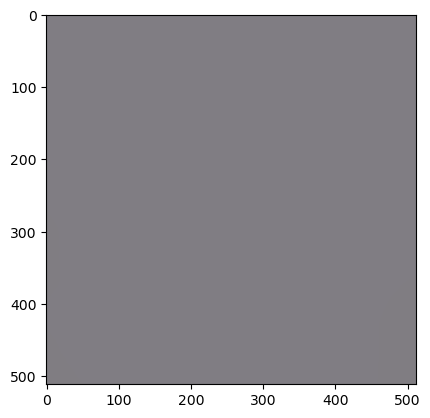

step=100, loss=0.057:   9%|█▊                 | 93/1000 [00:02<00:10, 89.34it/s]

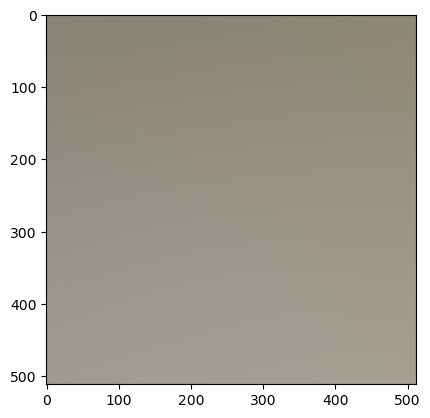

step=200, loss=0.053:  19%|███▍              | 190/1000 [00:03<00:08, 96.92it/s]

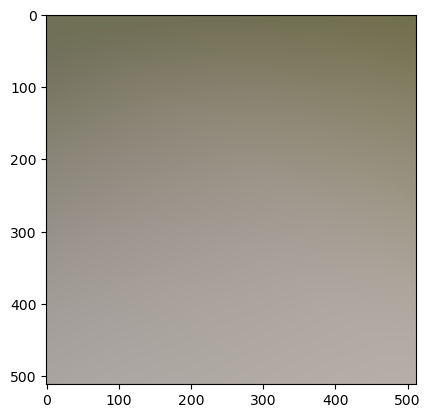

step=300, loss=0.051:  30%|█████▍            | 300/1000 [00:04<00:07, 99.95it/s]

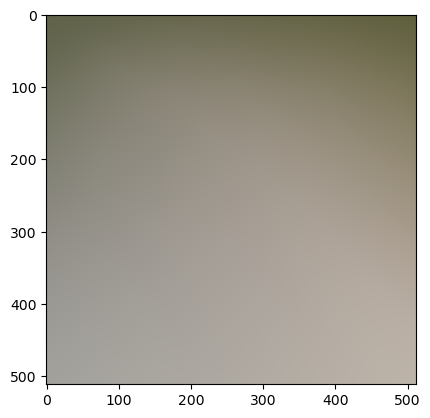

step=400, loss=0.049:  40%|███████▏          | 398/1000 [00:05<00:06, 99.20it/s]

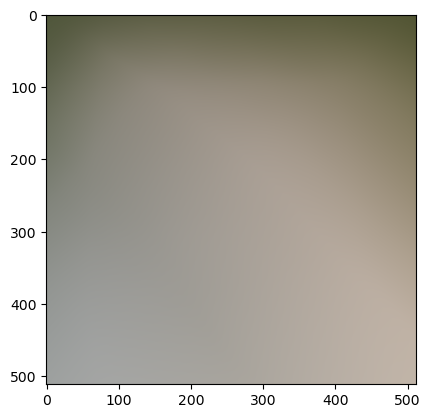

step=500, loss=0.043:  50%|████████▉         | 497/1000 [00:06<00:05, 98.87it/s]

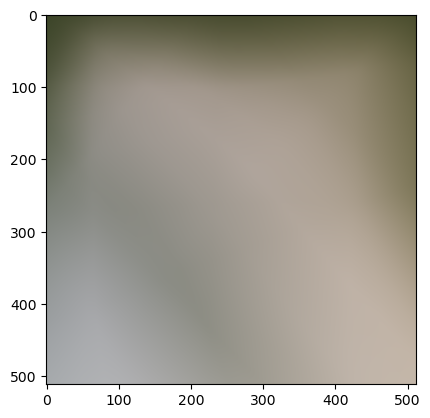

step=600, loss=0.034:  60%|██████████▋       | 596/1000 [00:07<00:04, 98.73it/s]

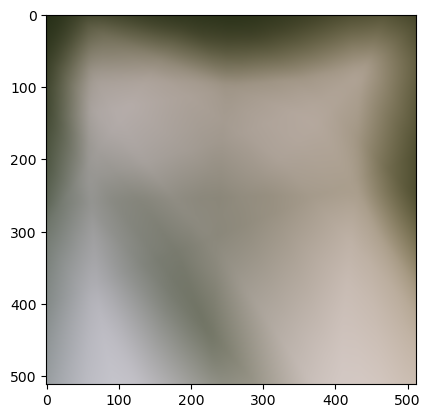

step=700, loss=0.029:  70%|████████████▌     | 695/1000 [00:08<00:03, 98.63it/s]

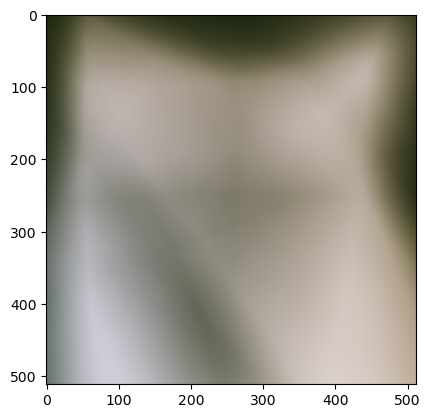

step=800, loss=0.026:  79%|██████████████▎   | 793/1000 [00:10<00:02, 97.76it/s]

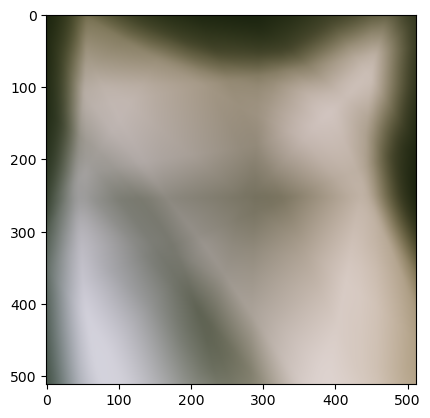

step=900, loss=0.025:  90%|████████████████▏ | 900/1000 [00:11<00:01, 98.06it/s]

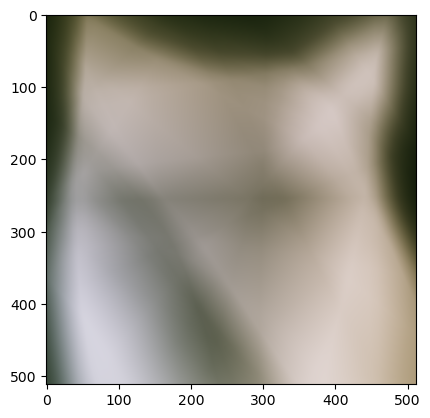

step=999, loss=0.024: 100%|█████████████████| 1000/1000 [00:12<00:00, 80.04it/s]


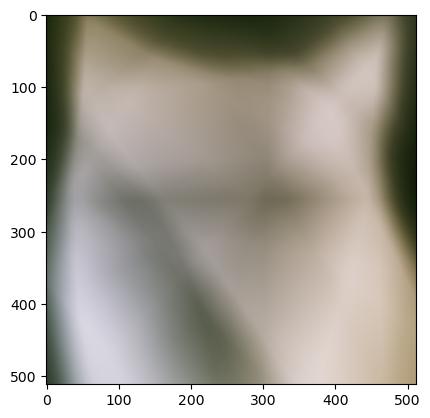

In [10]:
mlp = MLP().to(DEVICE)
optimizer = torch.optim.Adam(params=mlp.parameters(), lr=1e-4)

fit(mlp, train_dataset, test_dataset, optimizer)

Как вы видите, за 1000 итераций получается соптимизировать только очень заблюренную картинку без каких-либо высокочастотных деталей.


Чтобы это исправить, давайте реализуем преобразование 2D координат в Fourier Features.

Для этого реализуйте функцию `fourier_features`.

Она принимает на вход:
* x : матрицу [$N\times2$] c 2D координатами
* B: случайную матрицу отображения 2D координат в фурье фичи [$N\times F$]
* F: количество синусоидный и косинусоидных фичей
* scale: стандартное отклонение $\sigma$ фичей ($b_{i,j} \sim N(0,\sigma^2)$)

Если `B is None`, нужно создать новую матрицу B, в обратном случае использовать понанную на вход

На выходе функция выдаёт:
* ffeatures: трансформированные координаты $x^\prime\in\mathbb{R}^{N\times 2F}$ = $[\cos(2\pi \mathbf{xB}), \sin(2\pi \mathbf{xB})]$ (здесь [  ] это конкатенация)
* B: матрица $\mathbf{B}$

Внимание: матрица $\mathbf{B}$ создаётся 1 раз перед оптимизацией и остаётся фиксированной на всём её протяжении

In [11]:
def fourier_features(x, B=None, F=256, scale=10):
    if B is None:
        print('Initialized B.')
        B = torch.rand((2, F), device=DEVICE) * scale

    x = 2 * np.pi * x @ B
    ffeatures = torch.cat([torch.sin(x), torch.cos(x)], dim=1)
    return ffeatures, B

Теперь создайте новый перцептрон, который отличается от предыдущего только фходной размерностью ($2F$ вместо $2$)

In [12]:
ffeatures, B = fourier_features(train_dataset.coords)
ffeatures.shape

Initialized B.


torch.Size([65536, 512])

In [13]:
# TODO: создать новый перцептрон


# FIXME: INHERIT FROM MLP
class FFMLP(nn.Module):

    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 3),
            nn.Sigmoid(),
        )

    def forward(self, coords: Tensor) -> Tensor:
        return self.model(coords)

И напишите новый оптимизационный цикл, в котором перед подачей в перцептрон координаты трансформируются с помощью функции `fourier_features`.

Так же прогоните 1000 итераций оптимизации и сравните получившиеся картинки с и без Fourier Features.

In [14]:
# TODO: написать новый оптимизационный цикл с Fourier Features
from typing import Optional


NUM_ITERS = 1000
LOG_IMG_INTERVAL = 100


def show_prediction(model: MLP, dataset: Coord2PixelDataset, B_mat: Tensor):
    with torch.no_grad():
        ffeatures, B_mat = fourier_features(dataset.coords, B_mat)
        pred_colors = model(ffeatures)

    plt.imshow(pred_colors.detach().cpu().reshape(dataset.from_mask.shape))
    plt.show()



def fit(model: FFMLP, train_set, test_set, optimizer, B_mat=None, n_iters=NUM_ITERS):
    for step in (pbar := tqdm(range(n_iters))):
        optimizer.zero_grad()

        ffeatures, B_mat = fourier_features(train_set.coords, B_mat)
        pred_colors = model(ffeatures)

        colors = train_set.colors
        loss = torch.nn.functional.mse_loss(pred_colors, colors)
        loss.backward()
        optimizer.step()
        pbar.set_description(f"{step=}, loss={loss.item():.2}")

        if step % LOG_IMG_INTERVAL == 0:
            show_prediction(model, test_set, B_mat)
    else:
        show_prediction(model, test_set, B_mat)
    return model, B_mat

step=0, loss=0.064:   0%|                              | 0/1000 [00:00<?, ?it/s]

Initialized B.


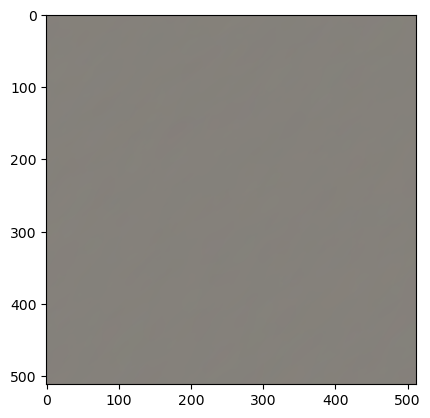

step=100, loss=0.034:  10%|█▉                 | 99/1000 [00:01<00:14, 61.13it/s]

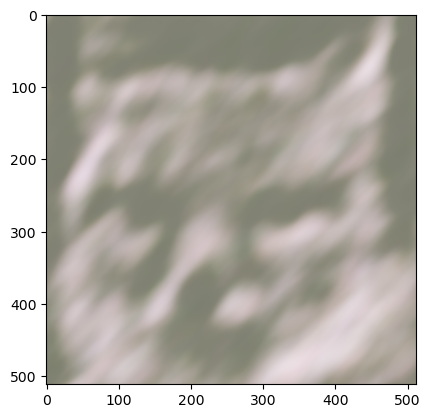

step=200, loss=0.0095:  20%|███▎             | 197/1000 [00:03<00:13, 60.74it/s]

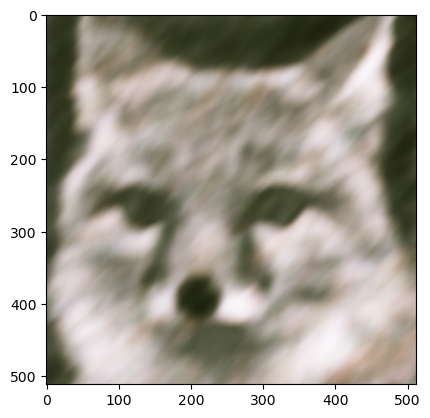

step=300, loss=0.0077:  30%|█████            | 295/1000 [00:05<00:11, 60.66it/s]

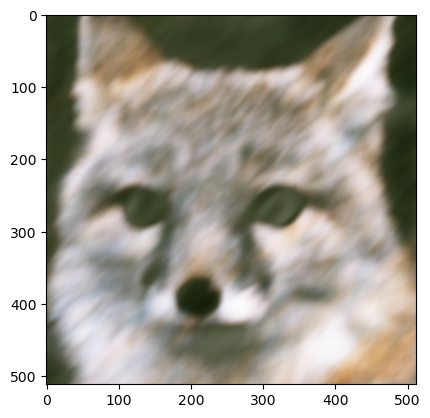

step=400, loss=0.0068:  40%|██████▊          | 399/1000 [00:07<00:10, 60.01it/s]

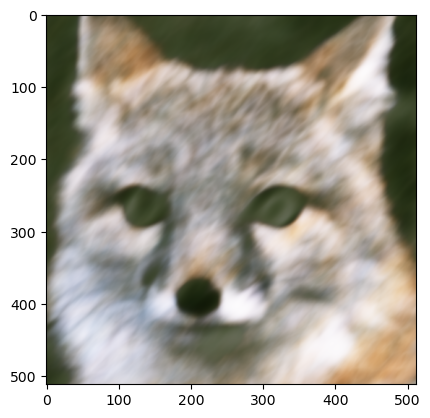

step=500, loss=0.0063:  50%|████████▍        | 496/1000 [00:09<00:08, 59.44it/s]

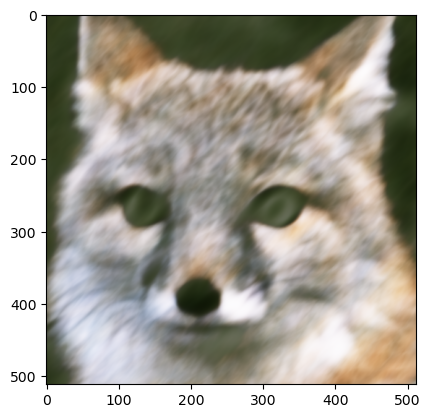

step=600, loss=0.0059:  60%|██████████       | 595/1000 [00:11<00:06, 60.26it/s]

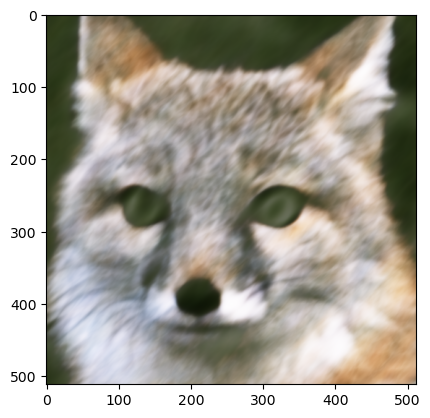

step=700, loss=0.0056:  70%|███████████▊     | 695/1000 [00:13<00:05, 59.81it/s]

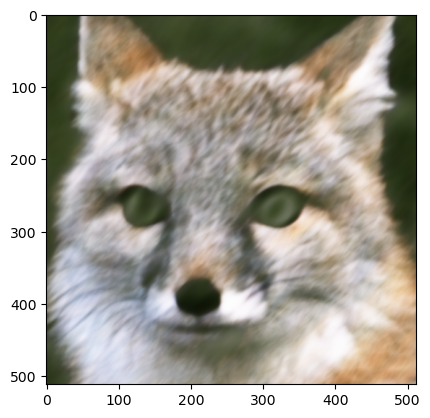

step=800, loss=0.0053:  79%|█████████████▍   | 794/1000 [00:14<00:03, 59.49it/s]

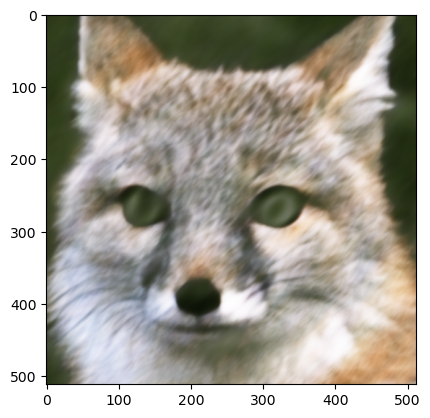

step=900, loss=0.0052:  90%|███████████████▏ | 895/1000 [00:16<00:01, 60.58it/s]

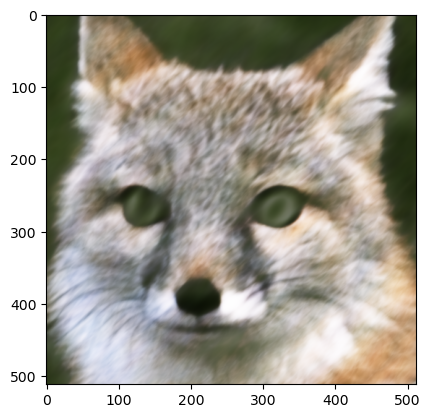

step=999, loss=0.005: 100%|█████████████████| 1000/1000 [00:18<00:00, 53.55it/s]


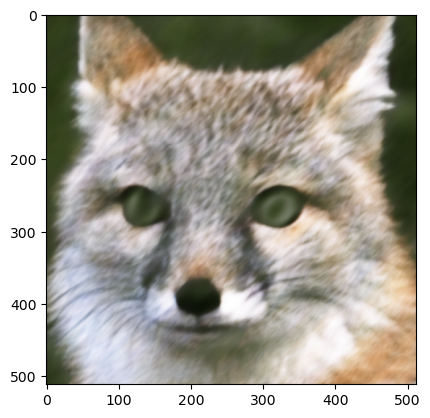

In [15]:
ff_mlp = FFMLP().to(DEVICE)
optimizer = torch.optim.Adam(params=ff_mlp.parameters(), lr=1e-4)


model, B_mat = fit(ff_mlp, train_dataset, test_dataset, optimizer)

# Задание 2: Eikonal loss

Во всех методах реконструкции SDF с помощью нейронных сетей используется Eikonal loss, который позволяет гарантировать хорошо-определённый SDF с нормой градиента по координатам в каждой точке равным 1.

Давайте реализуем этот лосс на практике и попробуем реконструировать 2хмерную SDF по набору разреженных точек.

Для начала сгерерируем набор 2D точек. Используйте для этого одну из функций `get_line_pointcloud` или `get_circumference_pointcloud`

In [26]:
import numpy as np

def get_line_pointcloud(N=20):
    x1 = np.array([0.2, 0])[:, None]
    x2 = np.array([0.8, 1])[:, None]


    N = 20
    r = np.random.rand(N)
    samples = x1 + r * (x2-x1)
    samples = samples.T
    return samples

def get_circumference_pointcloud(N=20, circle_r=0.3, circle_x=0.5, circle_y=0.5):
    # random angle
    alpha = 2 * np.pi * np.random.rand(N)
    # random radius
    r = circle_r 
    # calculating coordinates
    x = r * np.cos(alpha) + circle_x
    y = r * np.sin(alpha) + circle_y
    
    samples = np.stack([x, y], axis=-1)
    return samples

# TODO: сгенерировать точки

Теперь создадим ещё один перцептрон. Можете использовать ту же архитектуру, что и в прошлом задании, но теперь с выходной размерностью 1 и без активационной функции на конце. 

На вход он будет принимать 2D координаты переведённые в Fourier Features (для этого задания советую использовать scale < 1)

In [113]:
# TODO: создать перцептрон

class SDFMLP(nn.Module):

    def __init__(self):
        super().__init__()
        # self.model = nn.Sequential(
        #     nn.Linear(512, 64),
        #     nn.ReLU(),
        #     nn.Linear(64, 128),
        #     nn.ReLU(),
        #     nn.Linear(128, 128),
        #     nn.ReLU(),
        #     nn.Linear(128, 64),
        #     nn.ReLU(),
        #     nn.Linear(64, 1),
        # )
        
        self.model = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
        )

    def forward(self, coords: Tensor) -> Tensor:
        return self.model(coords)


Перед тем как начать писать оптимизационный цикл, давайте ещё реализуем функцию `sample_points`.

На каждом шаге наш тестовый датасет, который мы будем подавать в модель будет состоять из 2х типов точек:
* точки на поверхности, которые мы создали выше и
* случайные точки в пространстве

Функция `sample_points` должна генерировать второй набор точек.

Этот набор  также в свою очередб состоит из двух типов точек:
* точки рядом с поверхностью, семплированные из нормального распределения $N(\cdot,\sigma^2)$ вокруг точек с поверхности. Их будет столько же, чтолько точек с поверхности
* случайные точки из равномерного распределения $U(0, 1)$, их можно брать совсем немного, например в 8 раз меньше, чем точек с поверхности


In [114]:
def sample_points(surface_points, sigma=0.1, requires_grad: bool=True) -> Tensor:
    """
    Generate random points
    
    params:
    surface_points: torch.Tensor [Nx2]
    sigma: standard deviation around surface points
    
    returns: torch.Tensor [(N+N//8)x2]: N points from N(., sigma^2) around surface_points plus N//8 points from U(0,1)
    """
    # TODO: реализовать
    surface_points = Tensor(surface_points).to(DEVICE)
    count = len(surface_points)
    near_surface = surface_points + torch.rand((count, 2), requires_grad=requires_grad).to(DEVICE) * sigma
    arbitrary = torch.rand((count // 8, 2), requires_grad=requires_grad).to(DEVICE)
    return torch.cat([near_surface, arbitrary])

Теперь напишем оптимизационный цикл вместе с лосс функциями.

На каждой итерации цикла:
1. Взять точки нажего датасета
2. К ним насемплировать случайных точек функцией `sample_points`
3. Всем входным точкам (и точкам поверхности и случайным) поставить `requires_grad=True` потому что мы будем считать по ним градиент 
4. Трансформировать в все точки в Faurier Features и прогнать через через MLP чтобы получить значения SDF в этих точках.
5. Для точек датасета посчитать $l_1$ лосс (SDF в них д.б. равна нулю): $\mathcal{L}_{surface} = \sum_i |f_\theta(x_{surface}^{(i)})|$
6. Посчитать градиент SDF по всем входным точкам $\nabla_x f_\theta(x)$ с помощью функции gradient
7. Посчитать Eikonal loss для всех точек: $\mathcal{L}_{eikonal} = \|\nabla_x f_\theta(x)-1\|_2$
8. Посчитать общий лосс: $\mathcal{L}_{total} = \mathcal{L}_{surface} + \lambda\mathcal{L}_{eikonal}$, $\lambda > 1$


Каждые 100 итераций, отрисовывайте SDF с помощью функции `plot_sdf`

In [115]:
import torch
from torch.autograd import grad
import matplotlib as mpl



def gradient(inputs, outputs):
    d_points = torch.ones_like(outputs, requires_grad=False, device=outputs.device)
    points_grad = grad(
        outputs=outputs,
        inputs=inputs,
        grad_outputs=d_points,
        create_graph=True,
        retain_graph=True,
        only_inputs=True)[0][:, -3:]
    return points_grad


# def plot_sdf(model, points, B, resolution=256):
#     """
#     Plot SDF with matplotlib

#     model: torch.nn.Module that takes [Nx2] tensor and outputs [Nx1] signed distances
#     points: numpy array [Px2] with surface points coordinates
#     resolution: plot resolution
#     """
#     assert B is not None

#     device = list(model.parameters())[0].device
#     colormap = viridis = mpl.colormaps['RdBu']

#     coords = np.linspace(0, 1, resolution, endpoint=False)
#     x_test = np.stack(np.meshgrid(coords, coords), -1)
#     x_test = torch.FloatTensor(x_test).to(device)
#     x_test, B = fourier_features(x_test, B)

#     y_test = model(x_test).reshape(resolution, resolution,1).detach().cpu().numpy()

#     # red is outside, blue is inside
#     img = colormap(-y_test+0.5)[:,:,0]
#     # break
#     plt.imshow(img)
#     plt.scatter(points[:, 0]*resolution, points[:,1]*resolution)
#     plt.show()


def plot_sdf(model, points, B, resolution=256, scale=10):
    """
    Plot SDF with matplotlib

    model: torch.nn.Module that takes [Nx2] tensor and outputs [Nx1] signed distances
    points: numpy array [Px2] with surface points coordinates
    resolution: plot resolution
    """
    assert B is not None

    device = list(model.parameters())[0].device
    colormap = viridis = mpl.colormaps['RdBu']

    coords = np.linspace(0, 1, resolution, endpoint=False)
    x_test = np.stack(np.meshgrid(coords, coords), -1).reshape(-1, 2)
    x_test = torch.FloatTensor(x_test).to(device)
    x_test, B = fourier_features(x_test, B, scale)

    y_test = model(x_test).reshape(resolution, resolution, 1).detach().cpu().numpy()

    # red is outside, blue is inside
    img = colormap(-y_test+0.5)[:,:,0]

    plt.imshow(img)
    points = points.detach().cpu().numpy()
    plt.scatter(points[:, 0]*resolution, points[:,1]*resolution)
    plt.show()

In [116]:
FOURIER_SCALE = 0.3


def fit(model: SDFMLP, surface_pts, n_iters: int, B_mat=None, lmbd=0.3, log_interval=100):
    
    surface_pts = Tensor(surface_pts).to(DEVICE)
    
    for step in (pbar := tqdm(range(n_iters))):
        optimizer.zero_grad()

        field_pts = sample_points(surface_pts)
        # field_pts.requires_grad = True
        surface_pts.requires_grad = True

        surface_feat, B_mat = fourier_features(surface_pts, B_mat, scale=FOURIER_SCALE)
        field_feat, B_mat = fourier_features(field_pts, B_mat, scale=FOURIER_SCALE)
        all_feat = torch.cat([surface_feat, field_feat])

        surface_pred = model(surface_feat)
        # field_pred = model(field_feat)
        all_pred = model(all_feat)

        # surface_loss = torch.nn.functional.l1_loss(surface_pred, torch.zeros_like(surface_pred))
        surface_loss = (surface_pred.abs()).mean()

        grad_val = gradient(all_feat, all_pred)
        eikonal_loss = ((grad_val.norm(2, dim=-1) - 1) ** 2).mean()

        loss = surface_loss + lmbd * eikonal_loss
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2)

        optimizer.step()
        pbar.set_description(f"{step=}, loss={loss.item():.2}, surface_loss={surface_loss.item():.2}, eikonal_loss={eikonal_loss.item():.2}")

        if step % log_interval == 0:
            plot_sdf(model, surface_pts, B_mat, scale=FOURIER_SCALE)
    else:
        plot_sdf(model, surface_pts, B_mat, scale=FOURIER_SCALE)
    return model, B_mat

step=0, loss=0.78, surface_loss=0.083, eikonal_loss=1.0:   0%| | 0/2000 [00:00<?

Initialized B.


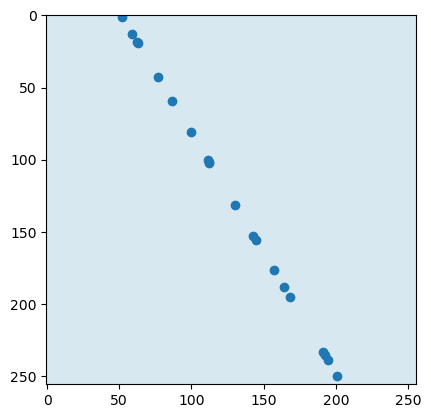

step=200, loss=0.7, surface_loss=0.00039, eikonal_loss=1.0:   9%| | 184/2000 [00

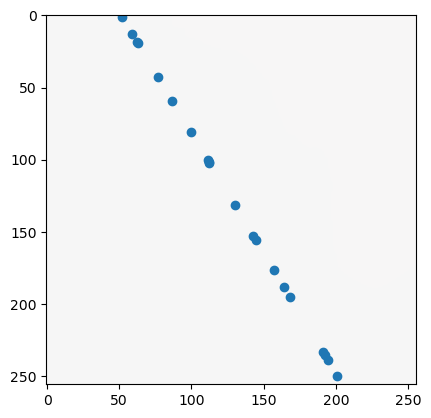

step=400, loss=0.67, surface_loss=0.0018, eikonal_loss=0.95:  20%|▏| 399/2000 [0

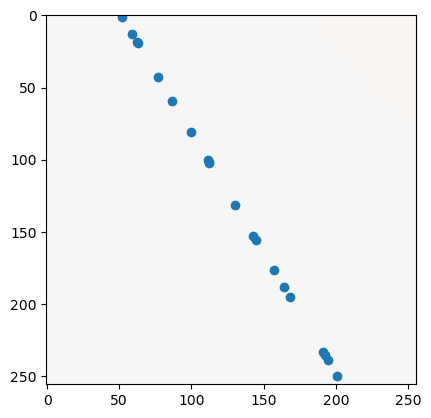

step=600, loss=0.12, surface_loss=0.014, eikonal_loss=0.15:  30%|▎| 590/2000 [00

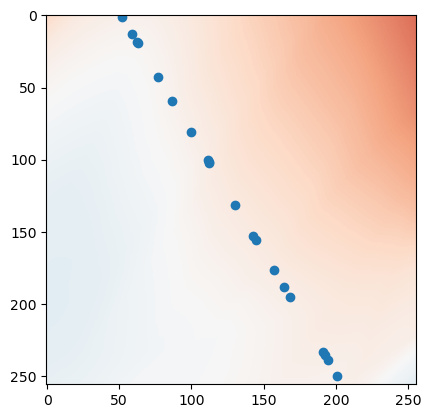

step=800, loss=0.056, surface_loss=0.04, eikonal_loss=0.022:  40%|▍| 793/2000 [0

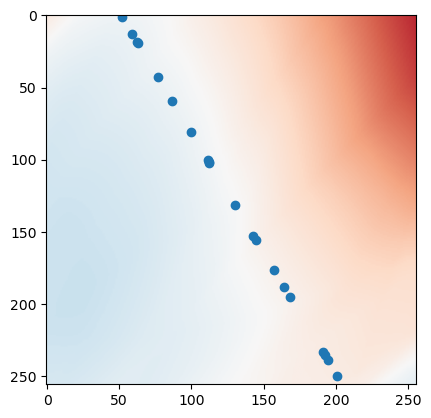

step=1000, loss=0.022, surface_loss=0.018, eikonal_loss=0.0059:  49%|▍| 988/2000

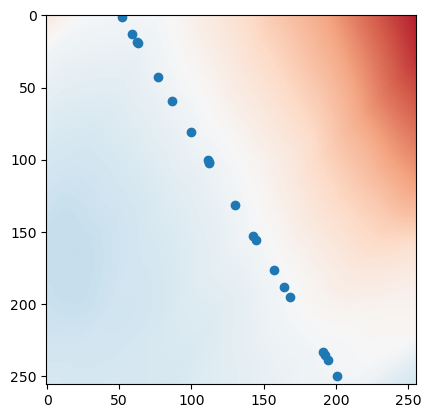

step=1200, loss=0.034, surface_loss=0.03, eikonal_loss=0.0046:  59%|▌| 1186/2000

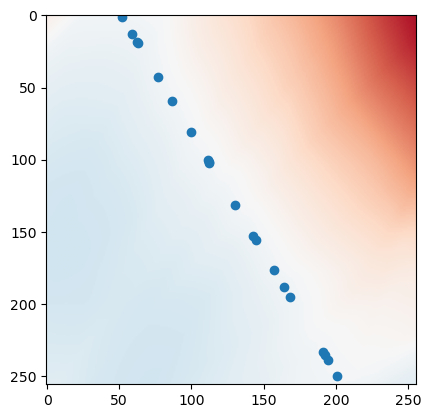

step=1400, loss=0.026, surface_loss=0.022, eikonal_loss=0.0044:  69%|▋| 1387/200

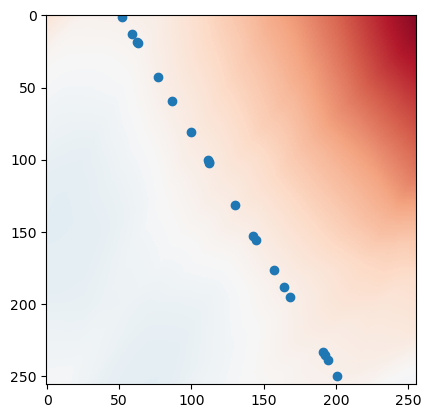

step=1600, loss=0.023, surface_loss=0.02, eikonal_loss=0.004:  80%|▊| 1594/2000 

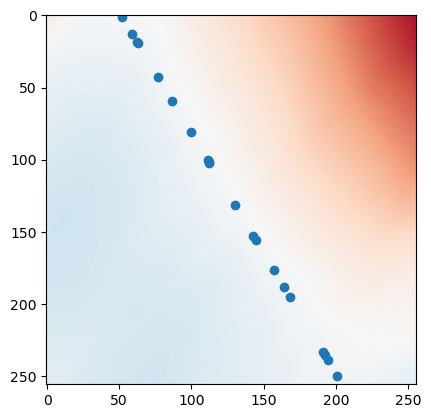

step=1800, loss=0.022, surface_loss=0.02, eikonal_loss=0.0021:  90%|▉| 1794/2000

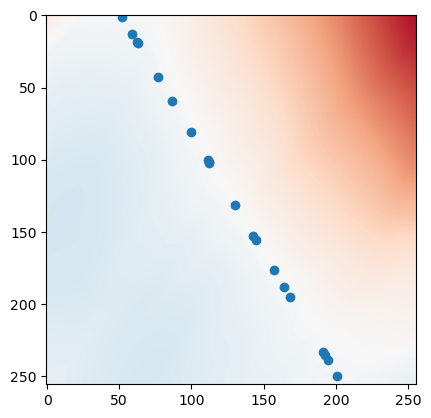

step=1999, loss=0.02, surface_loss=0.016, eikonal_loss=0.0055: 100%|█| 2000/2000


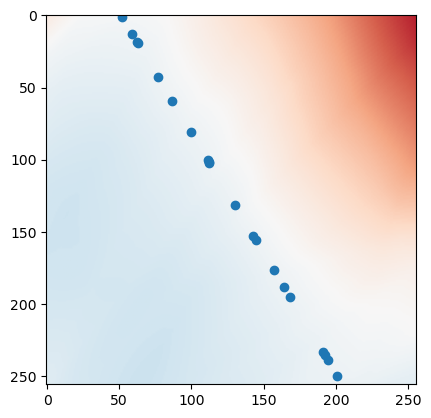

In [117]:
sdf_mlp = SDFMLP().to(DEVICE)
optimizer = torch.optim.Adam(params=sdf_mlp.parameters(), lr=1e-4)

surface_pts = get_line_pointcloud()
# surface_pts = get_circumference_pointcloud()

sdf_mlp, B_mat = fit(sdf_mlp, surface_pts, n_iters=2000, log_interval=200, lmbd=0.7)

step=0, loss=0.76, surface_loss=0.063, eikonal_loss=1.0:   0%| | 0/4000 [00:00<?

Initialized B.


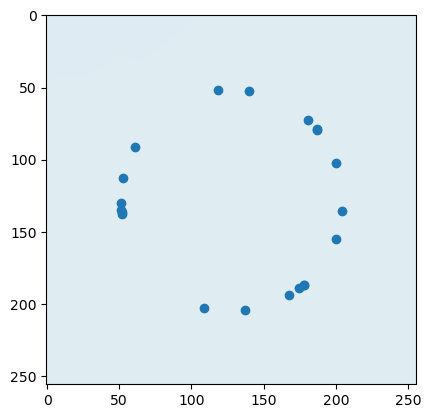

step=400, loss=0.7, surface_loss=4.1e-05, eikonal_loss=1.0:  10%| | 393/4000 [00

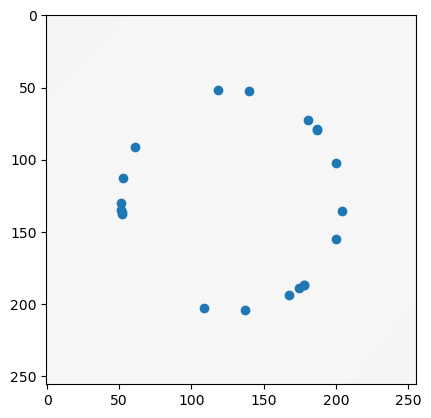

step=800, loss=0.7, surface_loss=3.2e-05, eikonal_loss=0.99:  20%|▏| 789/4000 [0

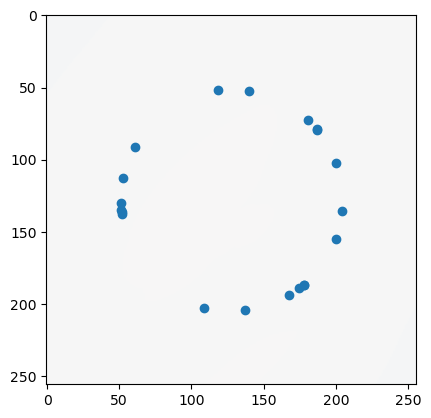

step=1200, loss=0.67, surface_loss=0.00061, eikonal_loss=0.96:  30%|▎| 1190/4000

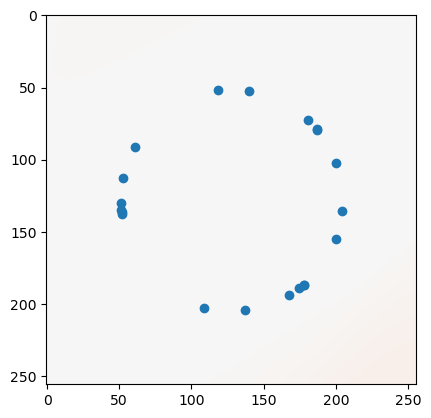

step=1600, loss=0.38, surface_loss=0.003, eikonal_loss=0.54:  40%|▍| 1589/4000 [

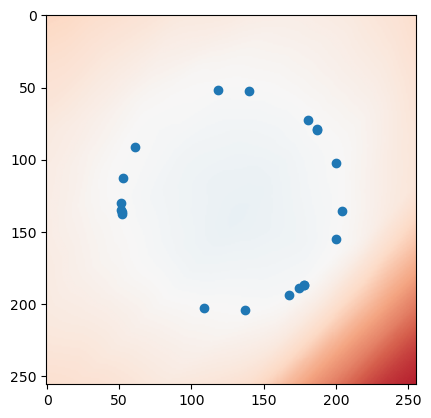

step=2000, loss=0.036, surface_loss=0.0068, eikonal_loss=0.042:  50%|▍| 1985/400

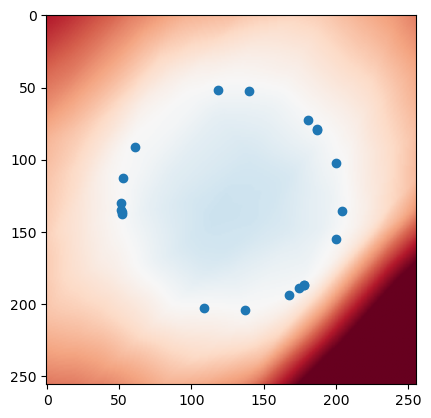

step=2400, loss=0.018, surface_loss=0.0027, eikonal_loss=0.022:  60%|▌| 2394/400

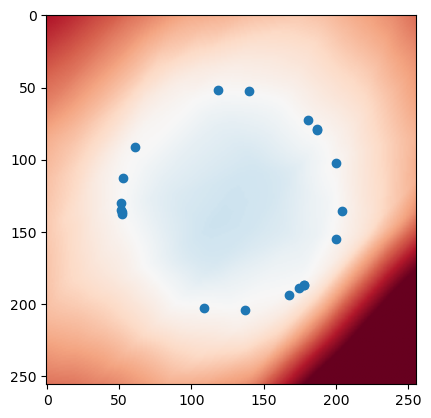

step=2800, loss=0.014, surface_loss=0.0033, eikonal_loss=0.015:  70%|▋| 2787/400

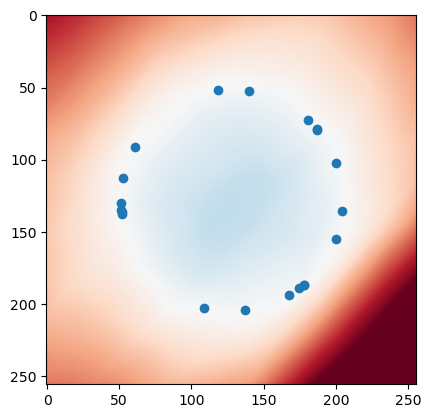

step=3200, loss=0.011, surface_loss=0.0021, eikonal_loss=0.012:  80%|▊| 3190/400

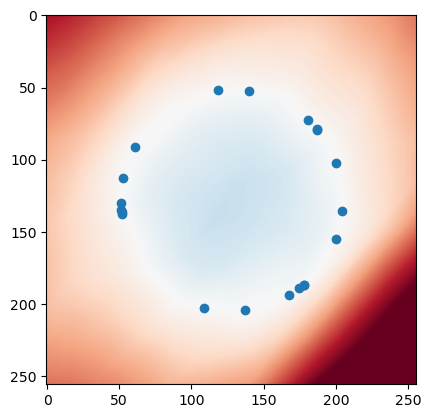

step=3600, loss=0.023, surface_loss=0.015, eikonal_loss=0.012:  90%|▉| 3591/4000

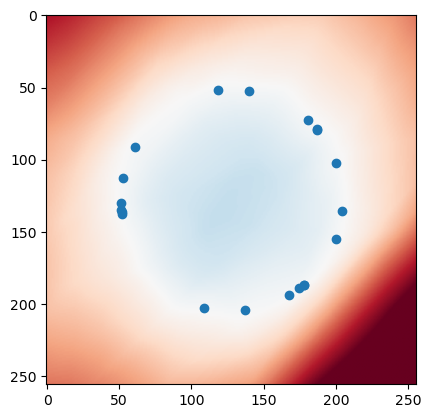

step=3999, loss=0.024, surface_loss=0.016, eikonal_loss=0.011: 100%|█| 4000/4000


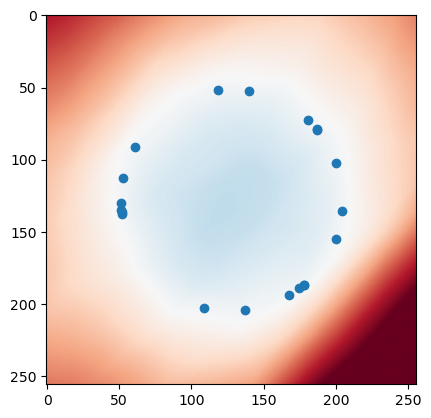

In [118]:
sdf_mlp = SDFMLP().to(DEVICE)
optimizer = torch.optim.Adam(params=sdf_mlp.parameters(), lr=3e-5)

# surface_pts = get_line_pointcloud()
surface_pts = get_circumference_pointcloud()

sdf_mlp, B_mat = fit(sdf_mlp, surface_pts, n_iters=4000, log_interval=400, lmbd=0.7)

в итоге должны получиться такие визуализации: 


![](data/sdf_circ.png)  |  ![](data/sdf_line.png)

# Задание 3: восстановление геометрии по видео


## Задание 3.1

Для этого задания будем использовать метод от NVidia, который называется [Neuralangelo](https://research.nvidia.com/labs/dir/neuralangelo/)

Мы не разбирали его на лекции, но он делает примерно то же самое, что NeUS, только сильно быстрее, потому что использует архитектуру InstantNGP (про неё Дима вам расскажет на следующей лекции).


В первой части этого задания, нужно будет просто запустить этот метод на игрушечных данных, которые они предоставляют.

Тут есть три варианта:
* Можете просто использовать их [коллаб](https://colab.research.google.com/drive/13u8DX9BNzQwiyPPCB7_4DbSxiQ5-_nGF)
* Установить себе докер контейнер ([инструкция](https://github.com/nvlabs/neuralangelo#installation))
* Либо установить себе их conda environment ([инструкция](https://github.com/nvlabs/neuralangelo#installation))
    * В этом случае ещё надо будет установить COLMAP ([инструкция](https://colmap.github.io/install.html))
        * Когда будете устанавливать COLMAP, деактивируйте все свои conda envorinments чтобы у вас был пустой `LD_LIBRARY_PATH`
        * Также когда будете запускать `cmake .. -GNinja`, добавьте к вызову флаг -DCMAKE_CUDA_ARCHITECTURES=*ARCH*, где *ARCH* это две цифры обозначающие архитектуру вашей ГПУ, их можно помотреть [тут](https://arnon.dk/matching-sm-architectures-arch-and-gencode-for-various-nvidia-cards/)
        Например, для 3060TI это 86
        
Затем скачайте данные и следуйте инструкциям из [коллаба](https://colab.research.google.com/drive/13u8DX9BNzQwiyPPCB7_4DbSxiQ5-_nGF)

В итоге должна получиться 3D модель трактора в `.ply` формате

Примечание? на 3060Ti оптимизация занимает ~80 минут

## Задание 3.2 (со звёздочкой)

Теперь давайте попробуем использовать Neuralangelo для in-the-wild видео.

Возьмите телефон или другую камеру и снимите видео с пролётом вокруг какого-нибудь объекта (используйте их видео с трактором как пример). Затем прогоните весь пайплайн на вашем видео.


Важные детали: 
* лучше выбирать объект, которые не содержит тонкие или полупрозрачные элементы
* COLMAP'у должно быть достаточно просто найти ключевые точки в видео. Лучше выбирать объект с контрастной текстурой либо снимать его на фоне, на котором просто найти ключевые точки
* По той же причине старайтесь избегать motion blur'a в видео. Если на вашем телефоне есть оптическая стабилизация, включите её, если нет, старайтесь двигаться медленно
* Когда будете разбивать видео на кадры, проследите, чтобы между картинками был достаточно большой baseline. Не следует брать кадры слишком близко друг к другу.